In [1]:
import pandas as pd
import pandas_profiling 
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
import pandas_profiling
from sklearn import svm
from sklearn.naive_bayes import GaussianNB  
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans


In [2]:
#train reading
train = pd.read_csv('dataset.csv', sep=';', low_memory=False )
train = train.dropna(thresh=130)

In [3]:
# UNBALANCED in percentage
train['TARGET'].value_counts()/ train['TARGET'].value_counts().sum() *100

0    98.58144
1     1.41856
Name: TARGET, dtype: float64

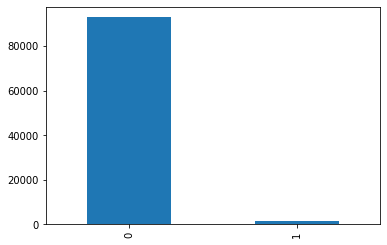

In [4]:
#seeing the unbalanced
train['TARGET'].value_counts().plot.bar()

In [5]:
#reading the test
test = pd.read_csv('test_dataset.csv', sep=';', low_memory=False )
cod_num = test['COD_NUM_TEL']

## features engineering

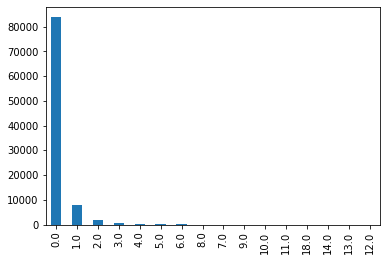

In [7]:
# looking at single features
train['NEEDS_RECLAMI_00_90_DAYS'].value_counts().plot.bar( )
plt.show()

In [8]:
#transforming features 

train['NEEDS_RECLAMI_00_90_DAYS'].loc[(train['NEEDS_RECLAMI_00_90_DAYS'] <= 3) & (train['NEEDS_RECLAMI_00_90_DAYS'] > 0)] = 1
train['NEEDS_RECLAMI_00_90_DAYS'].loc[train['NEEDS_RECLAMI_00_90_DAYS'] > 3] = 4
train['NEEDS_RECLAMI_00_90_DAYS'].loc[train['NEEDS_RECLAMI_00_90_DAYS'] == 0] = 'no_complaints'
train['NEEDS_RECLAMI_00_90_DAYS'].loc[train['NEEDS_RECLAMI_00_90_DAYS'] == 1] = 'many_complaints'
train['NEEDS_RECLAMI_00_90_DAYS'].loc[train['NEEDS_RECLAMI_00_90_DAYS'] == 4] = 'outrage'



test['NEEDS_RECLAMI_00_90_DAYS'].loc[(test['NEEDS_RECLAMI_00_90_DAYS'] <= 3) & (test['NEEDS_RECLAMI_00_90_DAYS'] > 0)] = 1
test['NEEDS_RECLAMI_00_90_DAYS'].loc[test['NEEDS_RECLAMI_00_90_DAYS'] > 3] = 4

test['NEEDS_RECLAMI_00_90_DAYS'].loc[test['NEEDS_RECLAMI_00_90_DAYS'] == 0] = 'no_complaints'
test['NEEDS_RECLAMI_00_90_DAYS'].loc[test['NEEDS_RECLAMI_00_90_DAYS'] == 1] = 'many_complaints'
test['NEEDS_RECLAMI_00_90_DAYS'].loc[test['NEEDS_RECLAMI_00_90_DAYS'] == 4] = 'outrage'


C:\Users\mccol\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


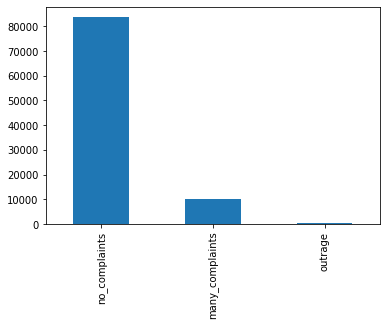

In [9]:
train['NEEDS_RECLAMI_00_90_DAYS'].value_counts().plot.bar()
plt.show()

# fill NaN

filling nan values. first of all dealing with the numerical features with nan and then with the categorical ones

In [73]:

numeric_feats = train.dtypes[train.dtypes != "object"].index

features = train[numeric_feats]
imp = SimpleImputer(strategy='median') 

imp = imp.fit(features)
imputed = imp.transform(features)
numeric_train = pd.DataFrame(imputed, columns= features.columns, index=train.index)

In [74]:
categorical_train = train.dtypes[train.dtypes == "object"].index
features = train[categorical_train]


In [76]:
new_train = pd.concat([numeric_train, features], axis=1)

In [78]:
new_train['FLG_RECLAMO_COMMERCIALE'] = new_train['FLG_RECLAMO_COMMERCIALE'].fillna('not_given')

In [80]:
new_train['NEEDS_RECLAMI_00_90_DAYS'] = new_train['NEEDS_RECLAMI_00_90_DAYS'].fillna('no_complaints')
new_train['DES_STATO_INSOLVENZA'] = new_train['DES_STATO_INSOLVENZA'].fillna('Bonus')
new_train['REGIONE'] = new_train['REGIONE'].fillna('tbd')
new_train['PROVINCIA'] = new_train['PROVINCIA'].fillna('tbd')
new_train['DESC_CANALE'] = new_train['DESC_CANALE'].fillna('CC 187')


In [81]:
new_train = new_train.dropna(subset=['S_VAR', 'S_TARGET'])

train = new_train

In [82]:
numeric_feats = test.dtypes[test.dtypes != "object"].index

features = test[numeric_feats]
imp = SimpleImputer(strategy='mean') #mean, most_frequent, constant

imp = imp.fit(features)
imputed = imp.transform(features)
numeric_test = pd.DataFrame(imputed, columns= features.columns, index = test.index)

In [84]:
categorical_test = test.dtypes[test.dtypes == "object"].index
features = test[categorical_train]


In [85]:
new_test = pd.concat([numeric_test, features], axis=1)

In [87]:
new_test['FLG_RECLAMO_COMMERCIALE'] = new_test['FLG_RECLAMO_COMMERCIALE'].fillna('not_given')
new_test['DES_STATO_INSOLVENZA'] = new_test['DES_STATO_INSOLVENZA'].fillna('Bonus')
new_test['REGIONE'] = new_test['REGIONE'].fillna('tbd')
new_test['PROVINCIA'] = new_test['PROVINCIA'].fillna('tbd')
new_test['DESC_CANALE'] = new_test['DESC_CANALE'].fillna('CC 187')
new_test['NEEDS_RECLAMI_00_90_DAYS'] = new_test['NEEDS_RECLAMI_00_90_DAYS'].fillna('no_complaints')


In [89]:
new_test = new_test.dropna(subset=['S_VAR', 'S_TARGET'])


test = new_test

## drop columns

dropping columns not helpful for our predictions

In [91]:
train = train.drop(['COD_NUM_TEL', 'COD_CAP_IMPIANTO', 'COMUNE', 'DATA_ATT_OFFERTA'], axis=1)
test = test.drop(['COD_NUM_TEL', 'COD_CAP_IMPIANTO', 'COMUNE', 'DATA_ATT_OFFERTA'], axis=1)

In [92]:
train['DAT_ATT_LINEA'] = train['DAT_ATT_LINEA'].apply(lambda x: x[:10])
train["DAT_ATT_LINEA"] = pd.to_numeric(train["DAT_ATT_LINEA"].str.replace('-', ''))


In [94]:
test['DAT_ATT_LINEA'] = test['DAT_ATT_LINEA'].apply(lambda x: x[:10])
test["DAT_ATT_LINEA"] = pd.to_numeric(test["DAT_ATT_LINEA"].str.replace('-', ''))


## NORMALIZATION

In [95]:
# log trasformation of skewed numeric features
from scipy.stats import skew
import matplotlib.pyplot as plt


numeric_feats = train.dtypes[train.dtypes != "object"].index

l = []
for i in numeric_feats:
    if min(train[numeric_feats][i]) < 0:
        l.append(i)
        
numeric_feats = set(numeric_feats) - set(l) - set(['TARGET'])

features = train[numeric_feats].apply(lambda x: skew(x.dropna())) 
features = features[features > 0.5]
features = features.index
train[features] = np.log1p(train[features])


In [96]:
# log trasformation of skewed numeric features
numeric_feats = test.dtypes[test.dtypes != "object"].index

l = []
for i in numeric_feats:
    if min(test[numeric_feats][i]) < 0:
        l.append(i)
        
numeric_feats = set(numeric_feats) - set(l) - set(['TARGET'])

features = test[numeric_feats].apply(lambda x: skew(x.dropna())) 
features = features[features > 0.5]
features = features.index
test[features] = np.log1p(test[features])

## GET DUMMIES

transformation of categorical features into binary-numerical 

In [97]:
y = train['TARGET']
train = train.drop(['TARGET'], axis = 1)

In [98]:
ui = pd.get_dummies(pd.concat([train,test], ignore_index=True) )

In [99]:
train = ui.iloc[:len(train)]
test = ui.iloc[len(train):]

In [100]:
train.shape, test.shape

((94321, 624), (28435, 624))

## DIMENSIONALITY REDUCTION

dropping columns that makes dataframe too sparse

In [101]:
overfit_list = []

for i in train.columns:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 80:

        overfit_list.append(i)

overfit_list = list(overfit_list)
train = train.drop(overfit_list, axis = 1).copy()
test = test.drop(overfit_list, axis=1).copy()


print('train', train.shape,'\n', 'y', y.shape, '\n', 'test', test.shape)

train (94321, 125) 
 y (94321,) 
 test (28435, 125)


## SCALER

scaling features to same magnitude

In [102]:
from sklearn.preprocessing import RobustScaler
col = train.columns
cols = test.columns
train = RobustScaler().fit(train).transform(train)
test = RobustScaler().fit(test).transform(test)

In [103]:
train = pd.DataFrame(train, columns= col )
test = pd.DataFrame(test, columns= col )

## OVERSAMPLING

rebalancing the dataframe with SMOTE

In [104]:
from imblearn.over_sampling import SMOTE, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE

X_resampled, y_resampled = SMOTE().fit_resample(train, y)

In [105]:
len(y_resampled)/2, y_resampled.sum()

(92983.0, 92983.0)

In [106]:
X_resampled = pd.DataFrame(X_resampled, columns= col )


## CV SPLITTING 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0)  


## MODEL SELECTION with grid search

In [97]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)


C:\Users\mccol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
y_pred = logreg.predict(X_test)


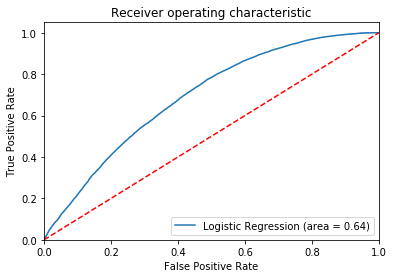

In [104]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [100]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63     23102
         1.0       0.63      0.66      0.64     23390

    accuracy                           0.64     46492
   macro avg       0.64      0.64      0.64     46492
weighted avg       0.64      0.64      0.64     46492



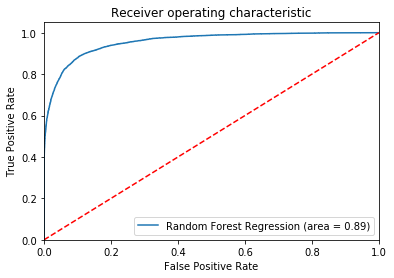

In [153]:
rfr = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=3)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rfr_roc_auc = roc_auc_score(y_test, rfr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rfr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [154]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     23102
         1.0       0.90      0.89      0.89     23390

    accuracy                           0.89     46492
   macro avg       0.89      0.89      0.89     46492
weighted avg       0.89      0.89      0.89     46492



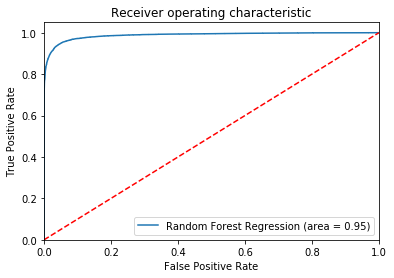

In [155]:
rfr = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=5)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rfr_roc_auc = roc_auc_score(y_test, rfr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rfr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     23102
         1.0       0.96      0.94      0.95     23390

    accuracy                           0.95     46492
   macro avg       0.95      0.95      0.95     46492
weighted avg       0.95      0.95      0.95     46492



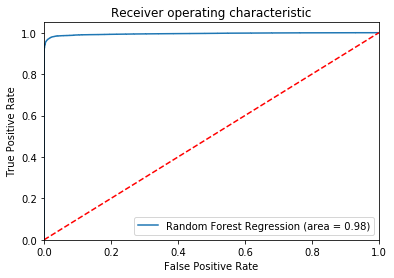

In [165]:
rfr = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=7)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rfr_roc_auc = roc_auc_score(y_test, rfr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rfr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [166]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     23102
         1.0       0.99      0.97      0.98     23390

    accuracy                           0.98     46492
   macro avg       0.98      0.98      0.98     46492
weighted avg       0.98      0.98      0.98     46492



In [335]:
rfr = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=5)
rfr.fit(X_resampled, y_resampled)
y_pred = rfr.predict_proba(test)[:,1]
y_pred

array([0.38274184, 0.41838073, 0.44768363, ..., 0.41887965, 0.24820655,
       0.32667523])

In [337]:
pd.DataFrame(rfr.feature_importances_, index = X_resampled.columns, columns=['importance']).sort_values('importance', ascending=False).head(10)


,importance
AGING_FASCE_LINEA_Oltre 10 anni,0.091431
DES_CAUSALE_ATT_LINEA_Attivazione,0.063659
FLAG_INTEGRATO_CONVERGENTE_INTEGRATO NON CONVERGENTE,0.060209
DES_CAUSALE_ATT_LINEA_*ND,0.058846
FASCIA_ETA_SINTESI_da 60 a 70,0.048596
DESC_CANALE_CC 187,0.046764
DURATA_PROMO_non in promo,0.045501
PROMO,0.041030
PROMO_ATTIVE_nessuna,0.037962
FLG_FATTURE_SCOPERTE_Y,0.036698


In [230]:
rfr = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=7)
rfr.fit(X_resampled, y_resampled)
y_pred = rfr.predict_proba(test)[:,1]
y_pred

array([0.33522044, 0.36017614, 0.42908362, ..., 0.38482989, 0.1890752 ,
       0.27123148])

In [ ]:
result = pd.DataFrame()

result['COD_NUM_TEL'] = cod_num
result['TARGET_PROB'] = y_pred
result.to_csv('prediction_DajeScientists.csv')

# clustering
unsupervised analysis

In [ ]:
rfr = RandomForestClassifier(n_estimators = 500, random_state=1, max_depth=7)
rfr.fit(X_resampled, y_resampled)
y_pred = rfr.predict(test)


In [ ]:
  
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, random_state=5).fit(test)
centroids = kmeans.cluster_centers_


In [152]:
clus = pd.DataFrame()
clus['CLUSTER'] = kmeans.labels_.astype(float)

clus['PRED'] = y_pred

In [153]:
not_equal = 0
index = []
ind = []
for i in clus.index:
    if (clus['CLUSTER'].iloc[i] != clus['PRED'].iloc[i]) :
        index.append(i)
        not_equal += 1
    if (clus['CLUSTER'].iloc[i] == clus['PRED'].iloc[i]) & (clus['PRED'].iloc[i] == 1):
        ind.append(i)

In [154]:
clus.iloc[index]

,CLUSTER,PRED,CLUSTER++
13,0.0,1.0,0.0
29,0.0,1.0,0.0
89,0.0,1.0,0.0
197,0.0,1.0,0.0
225,1.0,0.0,1.0
...,...,...,...
28157,0.0,1.0,0.0
28164,0.0,1.0,0.0
28166,1.0,0.0,1.0
28193,0.0,1.0,0.0
